[View in Colaboratory](https://colab.research.google.com/github/redcican/Master-Thesis/blob/master/15_Activation_Functions_Regression_Simple_Calories_data.ipynb)

# 15 Comparison of Activation Functions Using Regression of Calories Data


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Calories_Regression.csv to Calories_Regression.csv
User uploaded file "Calories_Regression.csv" with length 604611 bytes


In [0]:
%matplotlib inline
%config InlineBacken.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, initializers, LeakyReLU, PReLU, regularizers, Dropout
from keras import optimizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
rawdf = pd.read_csv('Calories_Regression.csv')
rawdf.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190,94,29,105,40.8,231
1,14861698,female,20,166,60,14,94,40.3,66
2,11179863,male,69,179,79,5,88,38.7,26
3,16180408,female,34,179,71,13,100,40.5,71
4,17771927,female,27,154,58,10,81,39.8,35


In [35]:
pd.options.display.float_format='{:,.5f}'.format
rawdf.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,"15,000.00000","15,000.00000","15,000.00000","15,000.00000","15,000.00000","15,000.00000","15,000.00000","15,000.00000"
mean,"14,977,358.53847",42.78980,174.46513,74.96687,15.53060,95.51853,40.02545,89.53953
std,"2,872,851.45223",16.98026,14.25811,15.03566,8.31920,9.58333,0.77923,62.45698
min,"10,001,159.00000",20.00000,123.00000,36.00000,1.00000,67.00000,37.10000,1.00000
25%,"12,474,190.75000",28.00000,164.00000,63.00000,8.00000,88.00000,39.60000,35.00000
50%,"14,997,285.00000",39.00000,175.00000,74.00000,16.00000,96.00000,40.20000,79.00000
75%,"17,449,278.75000",56.00000,185.00000,87.00000,23.00000,103.00000,40.60000,138.00000
max,"19,999,647.00000",79.00000,222.00000,132.00000,30.00000,128.00000,41.50000,314.00000


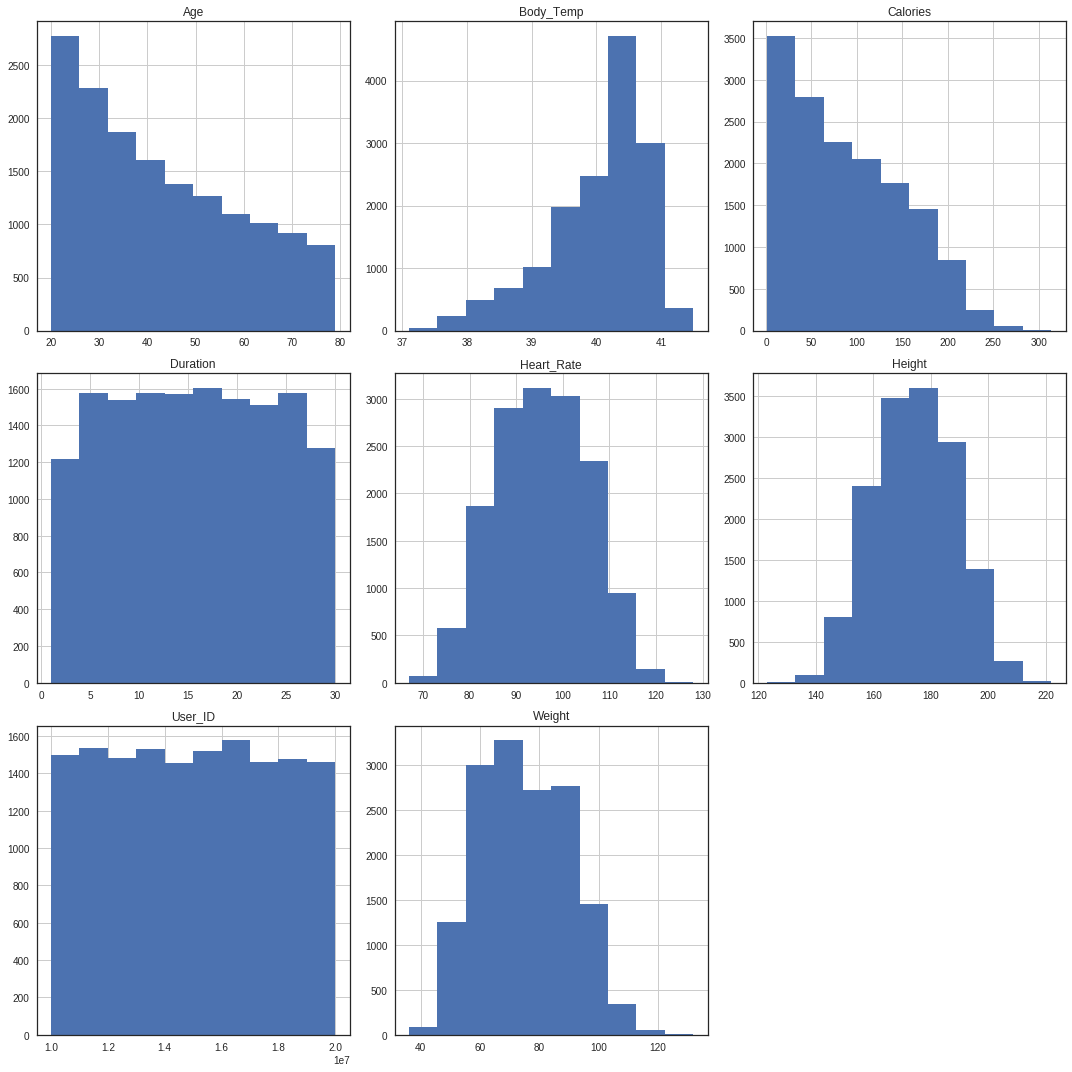

In [36]:
plt.style.use('seaborn-white')
rawdf.hist(figsize=(15,15))
plt.tight_layout()

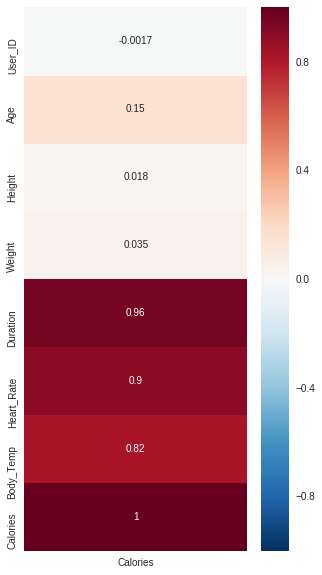

In [8]:
plt.figure(figsize=(5,10))
sns.heatmap(rawdf.corr()[['Calories']], annot=True, vmin=-1,vmax=1,)

In [0]:
df = rawdf.copy()

# make feature "Gender" to categorical
categorical_features = ["Gender"]
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# mathmatical operation 
pow2_features = ["Heart_Rate","Duration"]
df_pow2 = df[pow2_features].pow(2)
df_pow2.rename(columns={'Heart_Rate': 'Heart_Rate_2','Duration':'Duration_2'}, inplace=True)
df = pd.concat([df,df_pow2],axis=1)

# Calculate log calories to ensure no negative predictions.
ln_feature = ["Calories"]
df_ln = np.log(df[ln_feature])
df_ln.rename(columns={'Calories':'Ln_Calories'},inplace=True)
df = pd.concat([df,df_ln],axis=1)

In [0]:
# Nomalize the data
# Standardize data Column names: Height,Weight,Heart_Rate,Body_Temp,Pow(Heart_Rate_$2)
ss = StandardScaler()
scale_features = ['Height', 'Weight', 'Heart_Rate','Body_Temp','Heart_Rate_2']
df[scale_features] = ss.fit_transform(df[scale_features])

# MinMax data Age,Duration,Pow(Duration_$2)
mm = MinMaxScaler()
mm_features = ['Age','Duration','Duration_2']
df[mm_features] = mm.fit_transform(df[mm_features])

In [39]:
df.head()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Gender_female,Gender_male,Heart_Rate_2,Duration_2,Ln_Calories
0,14733363,0.81356,1.08958,1.26591,0.96552,0.98940,0.99402,231,0,1,0.98719,0.93437,5.44242
1,14861698,0.00000,-0.59373,-0.99546,0.44828,-0.15846,0.35234,66,1,0,-0.20712,0.21691,4.18965
2,11179863,0.83051,0.31807,0.26825,0.13793,-0.78457,-1.70104,26,0,1,-0.80292,0.02670,3.25810
3,16180408,0.23729,0.31807,-0.26384,0.41379,0.46765,0.60901,71,1,0,0.42795,0.18687,4.26268
4,17771927,0.11864,-1.43538,-1.12848,0.31034,-1.51503,-0.28934,35,1,0,-1.44836,0.11012,3.55535


In [40]:
X = df.drop(['User_ID','Calories'],axis=1).values
y = (df['Ln_Calories'].values).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12000, 11) (12000, 1) (3000, 11) (3000, 1)


##  1. Using Sigmoid Function

In [0]:
epochs = 50
batch_size = 256

In [75]:
model_1 = Sequential()
model_1.add(Dense(32, input_shape=(X.shape[1],), activation='sigmoid'))
model_1.add(Dense(32, activation='sigmoid'))
model_1.add(Dense(16, activation='sigmoid'))
model_1.add(Dense(1))
  
model_1.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_1_history = model_1.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))


Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 16.8526 - acc: 5.8333e-04 - val_loss: 11.3633 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 8.2283 - acc: 0.0000e+00 - val_loss: 5.8680 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 4.5730 - acc: 0.0000e+00 - val_loss: 3.5836 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 2.9820 - acc: 0.0000e+00 - val_loss: 2.5013 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 2.1663 - acc: 0.0000e+00 - val_loss: 1.8876 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 1.6850 - acc: 0.0000e+00 - val_loss: 1.5111 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 1.3847 - acc: 0.0000e+00 - val_loss: 1.2730 - val_acc: 0.0000e+00
Epoch 8/50
 - 0s - loss: 1.1951 - acc: 0.0000e+00 - val_loss: 1.1197 - val_acc: 0.0000e+00
Epoch 9/50
 - 0s - loss: 1.0725 - acc: 0.0000e+00 - val_loss: 1.0196 - val_acc: 0.0000e+00
Epoch 10/50
 - 0s - loss: 0.9896 - acc: 0.0000e+00 - val_loss: 0.9497 - val_acc: 0.0000e+00
Epoch 11/50
 - 0s - loss: 0.9289 - acc

Epoch 33/50
 - 0s - loss: 0.0689 - acc: 0.0000e+00 - val_loss: 0.0642 - val_acc: 0.0000e+00
Epoch 34/50
 - 0s - loss: 0.0637 - acc: 0.0000e+00 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 35/50
 - 0s - loss: 0.0591 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 36/50
 - 0s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 37/50
 - 0s - loss: 0.0516 - acc: 0.0000e+00 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 38/50
 - 0s - loss: 0.0485 - acc: 0.0000e+00 - val_loss: 0.0464 - val_acc: 0.0000e+00
Epoch 39/50
 - 0s - loss: 0.0458 - acc: 0.0000e+00 - val_loss: 0.0442 - val_acc: 0.0000e+00
Epoch 40/50
 - 0s - loss: 0.0434 - acc: 0.0000e+00 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 41/50
 - 0s - loss: 0.0413 - acc: 0.0000e+00 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 42/50
 - 0s - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0385 - val_acc: 0.0000e+00
Epoch 43/50
 - 0s - loss: 0.0376 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc:

## 2. Using Tanh

In [76]:
model_2 = Sequential()
model_2.add(Dense(32, input_shape=(X.shape[1],), activation='tanh'))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dense(16, activation='tanh'))
model_2.add(Dense(1))
  
model_2.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_2_history = model_2.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 3.3417 - acc: 4.1667e-04 - val_loss: 0.2223 - val_acc: 3.3333e-04
Epoch 2/50
 - 0s - loss: 0.1365 - acc: 8.3333e-05 - val_loss: 0.0950 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.0760 - acc: 0.0000e+00 - val_loss: 0.0590 - val_acc: 3.3333e-04
Epoch 4/50
 - 0s - loss: 0.0501 - acc: 5.0000e-04 - val_loss: 0.0424 - val_acc: 1.0000e-03
Epoch 5/50
 - 0s - loss: 0.0380 - acc: 6.6667e-04 - val_loss: 0.0342 - val_acc: 1.0000e-03
Epoch 6/50
 - 0s - loss: 0.0318 - acc: 7.5000e-04 - val_loss: 0.0297 - val_acc: 1.0000e-03
Epoch 7/50
 - 0s - loss: 0.0281 - acc: 7.5000e-04 - val_loss: 0.0268 - val_acc: 1.0000e-03
Epoch 8/50
 - 0s - loss: 0.0257 - acc: 7.5000e-04 - val_loss: 0.0248 - val_acc: 1.0000e-03
Epoch 9/50
 - 0s - loss: 0.0236 - acc: 7.5000e-04 - val_loss: 0.0229 - val_acc: 1.0000e-03
Epoch 10/50
 - 0s - loss: 0.0220 - acc: 7.5000e-04 - val_loss: 0.0216 - val_acc: 1.0000e-03
Epoch 11/50
 - 0s - loss: 0.0206 - acc: 

Epoch 33/50
 - 0s - loss: 0.0038 - acc: 7.5000e-04 - val_loss: 0.0036 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 0.0035 - acc: 7.5000e-04 - val_loss: 0.0034 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 0.0033 - acc: 7.5000e-04 - val_loss: 0.0031 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 0.0031 - acc: 7.5000e-04 - val_loss: 0.0030 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 0.0029 - acc: 7.5000e-04 - val_loss: 0.0027 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 0.0027 - acc: 7.5000e-04 - val_loss: 0.0026 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 0.0026 - acc: 7.5000e-04 - val_loss: 0.0025 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 0.0024 - acc: 7.5000e-04 - val_loss: 0.0023 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 0.0023 - acc: 7.5000e-04 - val_loss: 0.0022 - val_acc: 1.0000e-03
Epoch 42/50
 - 0s - loss: 0.0021 - acc: 7.5000e-04 - val_loss: 0.0020 - val_acc: 1.0000e-03
Epoch 43/50
 - 0s - loss: 0.0020 - acc: 7.5000e-04 - val_loss: 0.0019 - val_acc:

## 3. Using ReLU

In [77]:
model_3 = Sequential()
model_3.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1))
  
model_3.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_3_history = model_3.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 5.4183 - acc: 2.5000e-04 - val_loss: 0.3664 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 0.1488 - acc: 0.0000e+00 - val_loss: 0.0766 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.0592 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 0.0324 - acc: 0.0000e+00 - val_loss: 0.0243 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 0.0092 - acc: 0.0000e+00 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 8/50
 - 0s - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0057 - val_acc: 0.0000e+00
Epoch 9/50
 - 0s - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 10/50
 - 0s - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 3.3333e-04
Epoch 11/50
 - 0s - loss: 0.0034 - acc: 

Epoch 33/50
 - 0s - loss: 5.4088e-04 - acc: 7.5000e-04 - val_loss: 5.0071e-04 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 5.0671e-04 - acc: 7.5000e-04 - val_loss: 4.7713e-04 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 4.8428e-04 - acc: 7.5000e-04 - val_loss: 4.7010e-04 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 4.5542e-04 - acc: 7.5000e-04 - val_loss: 4.2531e-04 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 4.3155e-04 - acc: 7.5000e-04 - val_loss: 4.3526e-04 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 4.1692e-04 - acc: 7.5000e-04 - val_loss: 3.8751e-04 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 3.9136e-04 - acc: 7.5000e-04 - val_loss: 3.6634e-04 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 3.7217e-04 - acc: 7.5000e-04 - val_loss: 3.5204e-04 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 3.5326e-04 - acc: 7.5000e-04 - val_loss: 3.3290e-04 - val_acc: 1.0000e-03
Epoch 42/50
 - 0s - loss: 3.3699e-04 - acc: 7.5000e-04 - val_loss: 3.2272e-04 - val_acc: 1.0000e-03


## 4. Using LeakyReLU


In [78]:
model_4 = Sequential()
model_4.add(Dense(32, input_shape=(X.shape[1],)))
model_4.add(LeakyReLU(0.01))
model_4.add(Dense(32))
model_4.add(LeakyReLU(0.01))
model_4.add(Dense(16))
model_4.add(LeakyReLU(0.01))
model_4.add(Dense(1))
  
model_4.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_4_history = model_4.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 14.1179 - acc: 7.5000e-04 - val_loss: 5.5214 - val_acc: 6.6667e-04
Epoch 2/50
 - 0s - loss: 1.0956 - acc: 8.3333e-05 - val_loss: 0.0309 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.0260 - acc: 4.1667e-04 - val_loss: 0.0153 - val_acc: 3.3333e-04
Epoch 4/50
 - 0s - loss: 0.0131 - acc: 5.8333e-04 - val_loss: 0.0102 - val_acc: 3.3333e-04
Epoch 5/50
 - 0s - loss: 0.0093 - acc: 6.6667e-04 - val_loss: 0.0080 - val_acc: 1.0000e-03
Epoch 6/50
 - 0s - loss: 0.0073 - acc: 7.5000e-04 - val_loss: 0.0065 - val_acc: 1.0000e-03
Epoch 7/50
 - 0s - loss: 0.0060 - acc: 7.5000e-04 - val_loss: 0.0053 - val_acc: 1.0000e-03
Epoch 8/50
 - 0s - loss: 0.0050 - acc: 7.5000e-04 - val_loss: 0.0045 - val_acc: 1.0000e-03
Epoch 9/50
 - 0s - loss: 0.0042 - acc: 7.5000e-04 - val_loss: 0.0039 - val_acc: 1.0000e-03
Epoch 10/50
 - 0s - loss: 0.0037 - acc: 7.5000e-04 - val_loss: 0.0035 - val_acc: 1.0000e-03
Epoch 11/50
 - 0s - loss: 0.0033 - acc:

Epoch 33/50
 - 0s - loss: 7.6502e-04 - acc: 7.5000e-04 - val_loss: 7.6962e-04 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 7.2452e-04 - acc: 7.5000e-04 - val_loss: 7.3104e-04 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 6.8271e-04 - acc: 7.5000e-04 - val_loss: 6.8500e-04 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 6.4225e-04 - acc: 7.5000e-04 - val_loss: 6.4933e-04 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 6.0511e-04 - acc: 7.5000e-04 - val_loss: 6.1113e-04 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 5.7261e-04 - acc: 7.5000e-04 - val_loss: 5.6918e-04 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 5.3528e-04 - acc: 7.5000e-04 - val_loss: 5.3742e-04 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 5.0292e-04 - acc: 7.5000e-04 - val_loss: 5.1018e-04 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 4.8034e-04 - acc: 7.5000e-04 - val_loss: 5.1192e-04 - val_acc: 1.0000e-03
Epoch 42/50
 - 0s - loss: 4.4682e-04 - acc: 7.5000e-04 - val_loss: 4.5275e-04 - val_acc: 1.0000e-03


## 5. Using PReLU

In [79]:
model_5 = Sequential()
model_5.add(Dense(32, input_shape=(X.shape[1],)))
model_5.add(PReLU())
model_5.add(Dense(32))
model_5.add(PReLU())
model_5.add(Dense(16))
model_5.add(PReLU())
model_5.add(Dense(1))
  
model_5.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_5_history = model_5.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 18.4383 - acc: 5.0000e-04 - val_loss: 12.7509 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 5.2042 - acc: 0.0000e+00 - val_loss: 0.6875 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.3123 - acc: 0.0000e+00 - val_loss: 0.1507 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 0.1078 - acc: 0.0000e+00 - val_loss: 0.0757 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 0.0588 - acc: 0.0000e+00 - val_loss: 0.0457 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0309 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 0.0266 - acc: 1.6667e-04 - val_loss: 0.0220 - val_acc: 3.3333e-04
Epoch 8/50
 - 0s - loss: 0.0195 - acc: 4.1667e-04 - val_loss: 0.0164 - val_acc: 6.6667e-04
Epoch 9/50
 - 0s - loss: 0.0150 - acc: 5.8333e-04 - val_loss: 0.0127 - val_acc: 1.0000e-03
Epoch 10/50
 - 0s - loss: 0.0119 - acc: 5.8333e-04 - val_loss: 0.0102 - val_acc: 1.0000e-03
Epoch 11/50
 - 0s - loss: 0.0098 - acc

Epoch 33/50
 - 0s - loss: 0.0020 - acc: 7.5000e-04 - val_loss: 0.0018 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 0.0019 - acc: 7.5000e-04 - val_loss: 0.0018 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 0.0018 - acc: 7.5000e-04 - val_loss: 0.0017 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 0.0018 - acc: 7.5000e-04 - val_loss: 0.0017 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 0.0017 - acc: 7.5000e-04 - val_loss: 0.0016 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 0.0017 - acc: 7.5000e-04 - val_loss: 0.0016 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 0.0016 - acc: 7.5000e-04 - val_loss: 0.0015 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 0.0015 - acc: 7.5000e-04 - val_loss: 0.0015 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 0.0015 - acc: 7.5000e-04 - val_loss: 0.0015 - val_acc: 1.0000e-03
Epoch 42/50
 - 0s - loss: 0.0015 - acc: 7.5000e-04 - val_loss: 0.0014 - val_acc: 1.0000e-03
Epoch 43/50
 - 0s - loss: 0.0014 - acc: 7.5000e-04 - val_loss: 0.0014 - val_acc:

## 6. Using Linear Function

In [80]:
model_6 = Sequential()
model_6.add(Dense(32, input_shape=(X.shape[1],)))
model_6.add(Dense(32, activation='linear'))
model_6.add(Dense(16, activation='linear'))
model_6.add(Dense(1))
  
model_6.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_6_history = model_6.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 1.7843 - acc: 5.0000e-04 - val_loss: 0.0842 - val_acc: 1.0000e-03
Epoch 2/50
 - 0s - loss: 0.0515 - acc: 7.5000e-04 - val_loss: 0.0294 - val_acc: 1.0000e-03
Epoch 3/50
 - 0s - loss: 0.0223 - acc: 7.5000e-04 - val_loss: 0.0153 - val_acc: 1.0000e-03
Epoch 4/50
 - 0s - loss: 0.0115 - acc: 7.5000e-04 - val_loss: 0.0078 - val_acc: 1.0000e-03
Epoch 5/50
 - 0s - loss: 0.0057 - acc: 7.5000e-04 - val_loss: 0.0039 - val_acc: 1.0000e-03
Epoch 6/50
 - 0s - loss: 0.0030 - acc: 7.5000e-04 - val_loss: 0.0023 - val_acc: 1.0000e-03
Epoch 7/50
 - 0s - loss: 0.0019 - acc: 7.5000e-04 - val_loss: 0.0016 - val_acc: 1.0000e-03
Epoch 8/50
 - 0s - loss: 0.0014 - acc: 7.5000e-04 - val_loss: 0.0013 - val_acc: 1.0000e-03
Epoch 9/50
 - 0s - loss: 0.0012 - acc: 7.5000e-04 - val_loss: 0.0011 - val_acc: 1.0000e-03
Epoch 10/50
 - 0s - loss: 0.0010 - acc: 7.5000e-04 - val_loss: 9.7516e-04 - val_acc: 1.0000e-03
Epoch 11/50
 - 0s - loss: 9.2623e-04

 - 0s - loss: 8.4376e-05 - acc: 7.5000e-04 - val_loss: 7.5980e-05 - val_acc: 1.0000e-03
Epoch 33/50
 - 0s - loss: 7.0722e-05 - acc: 7.5000e-04 - val_loss: 6.5178e-05 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 6.0773e-05 - acc: 7.5000e-04 - val_loss: 5.5037e-05 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 4.9706e-05 - acc: 7.5000e-04 - val_loss: 4.6972e-05 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 4.1134e-05 - acc: 7.5000e-04 - val_loss: 3.8203e-05 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 3.3994e-05 - acc: 7.5000e-04 - val_loss: 3.0343e-05 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 2.7643e-05 - acc: 7.5000e-04 - val_loss: 2.4971e-05 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 2.2356e-05 - acc: 7.5000e-04 - val_loss: 1.9889e-05 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 1.8367e-05 - acc: 7.5000e-04 - val_loss: 1.6699e-05 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 1.4565e-05 - acc: 7.5000e-04 - val_loss: 1.3261e-05 - val_acc: 1.0000e-03
Epoch 42/50


## 7. Using Elu

In [81]:
model_7 = Sequential()
model_7.add(Dense(32, input_shape=(X.shape[1],), activation='elu'))
model_7.add(Dense(32, activation='elu'))
model_7.add(Dense(16, activation='elu'))
model_7.add(Dense(1))
model_7.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_7_history = model_7.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 2.4504 - acc: 0.0000e+00 - val_loss: 0.1039 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 0.0728 - acc: 0.0000e+00 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 0.0337 - acc: 8.3333e-05 - val_loss: 0.0276 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 0.0225 - acc: 1.6667e-04 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 0.0168 - acc: 3.3333e-04 - val_loss: 0.0154 - val_acc: 6.6667e-04
Epoch 6/50
 - 0s - loss: 0.0134 - acc: 7.5000e-04 - val_loss: 0.0125 - val_acc: 1.0000e-03
Epoch 7/50
 - 0s - loss: 0.0112 - acc: 7.5000e-04 - val_loss: 0.0107 - val_acc: 1.0000e-03
Epoch 8/50
 - 0s - loss: 0.0097 - acc: 7.5000e-04 - val_loss: 0.0094 - val_acc: 1.0000e-03
Epoch 9/50
 - 0s - loss: 0.0086 - acc: 7.5000e-04 - val_loss: 0.0084 - val_acc: 1.0000e-03
Epoch 10/50
 - 0s - loss: 0.0078 - acc: 7.5000e-04 - val_loss: 0.0076 - val_acc: 1.0000e-03
Epoch 11/50
 - 0s - loss: 0.0072 - acc: 

Epoch 33/50
 - 0s - loss: 0.0012 - acc: 7.5000e-04 - val_loss: 0.0012 - val_acc: 1.0000e-03
Epoch 34/50
 - 0s - loss: 0.0012 - acc: 7.5000e-04 - val_loss: 0.0011 - val_acc: 1.0000e-03
Epoch 35/50
 - 0s - loss: 0.0011 - acc: 7.5000e-04 - val_loss: 0.0011 - val_acc: 1.0000e-03
Epoch 36/50
 - 0s - loss: 0.0010 - acc: 7.5000e-04 - val_loss: 0.0010 - val_acc: 1.0000e-03
Epoch 37/50
 - 0s - loss: 9.7511e-04 - acc: 7.5000e-04 - val_loss: 9.7491e-04 - val_acc: 1.0000e-03
Epoch 38/50
 - 0s - loss: 9.3560e-04 - acc: 7.5000e-04 - val_loss: 9.1882e-04 - val_acc: 1.0000e-03
Epoch 39/50
 - 0s - loss: 8.9144e-04 - acc: 7.5000e-04 - val_loss: 8.7411e-04 - val_acc: 1.0000e-03
Epoch 40/50
 - 0s - loss: 8.4796e-04 - acc: 7.5000e-04 - val_loss: 8.3035e-04 - val_acc: 1.0000e-03
Epoch 41/50
 - 0s - loss: 8.1553e-04 - acc: 7.5000e-04 - val_loss: 8.0937e-04 - val_acc: 1.0000e-03
Epoch 42/50
 - 0s - loss: 7.8214e-04 - acc: 7.5000e-04 - val_loss: 7.6162e-04 - val_acc: 1.0000e-03
Epoch 43/50
 - 0s - loss: 7.5081

## 8. Using hard_sigmoid


In [82]:
model_8 = Sequential()
model_8.add(Dense(32, input_shape=(X.shape[1],), activation='hard_sigmoid'))
model_8.add(Dense(32, activation='hard_sigmoid'))
model_8.add(Dense(16, activation='hard_sigmoid'))
model_8.add(Dense(1))
  
model_8.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model_8_history = model_8.fit(X_train, y_train,
                             batch_size = batch_size,
                             epochs = epochs,
                             verbose = 2,
                             validation_data=(X_test,y_test))

Train on 12000 samples, validate on 3000 samples
Epoch 1/50
 - 1s - loss: 6.4197 - acc: 0.0000e+00 - val_loss: 3.2478 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 1.8565 - acc: 0.0000e+00 - val_loss: 1.1494 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 1.0155 - acc: 0.0000e+00 - val_loss: 0.8979 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 0.8337 - acc: 0.0000e+00 - val_loss: 0.7631 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 0.7256 - acc: 0.0000e+00 - val_loss: 0.6689 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 0.6161 - acc: 0.0000e+00 - val_loss: 0.5417 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 0.4919 - acc: 0.0000e+00 - val_loss: 0.4333 - val_acc: 0.0000e+00
Epoch 8/50
 - 0s - loss: 0.3938 - acc: 0.0000e+00 - val_loss: 0.3415 - val_acc: 0.0000e+00
Epoch 9/50
 - 0s - loss: 0.3068 - acc: 0.0000e+00 - val_loss: 0.2616 - val_acc: 0.0000e+00
Epoch 10/50
 - 0s - loss: 0.2334 - acc: 0.0000e+00 - val_loss: 0.1962 - val_acc: 0.0000e+00
Epoch 11/50
 - 0s - loss: 0.1764 - acc: 

Epoch 33/50
 - 0s - loss: 0.0203 - acc: 0.0000e+00 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 34/50
 - 0s - loss: 0.0195 - acc: 0.0000e+00 - val_loss: 0.0195 - val_acc: 0.0000e+00
Epoch 35/50
 - 0s - loss: 0.0188 - acc: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 36/50
 - 0s - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.0180 - val_acc: 0.0000e+00
Epoch 37/50
 - 0s - loss: 0.0173 - acc: 0.0000e+00 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 38/50
 - 0s - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0167 - val_acc: 0.0000e+00
Epoch 39/50
 - 0s - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 40/50
 - 0s - loss: 0.0154 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 41/50
 - 0s - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 42/50
 - 0s - loss: 0.0142 - acc: 0.0000e+00 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 43/50
 - 0s - loss: 0.0136 - acc: 0.0000e+00 - val_loss: 0.0138 - val_acc:

## Plot the Result and Compare

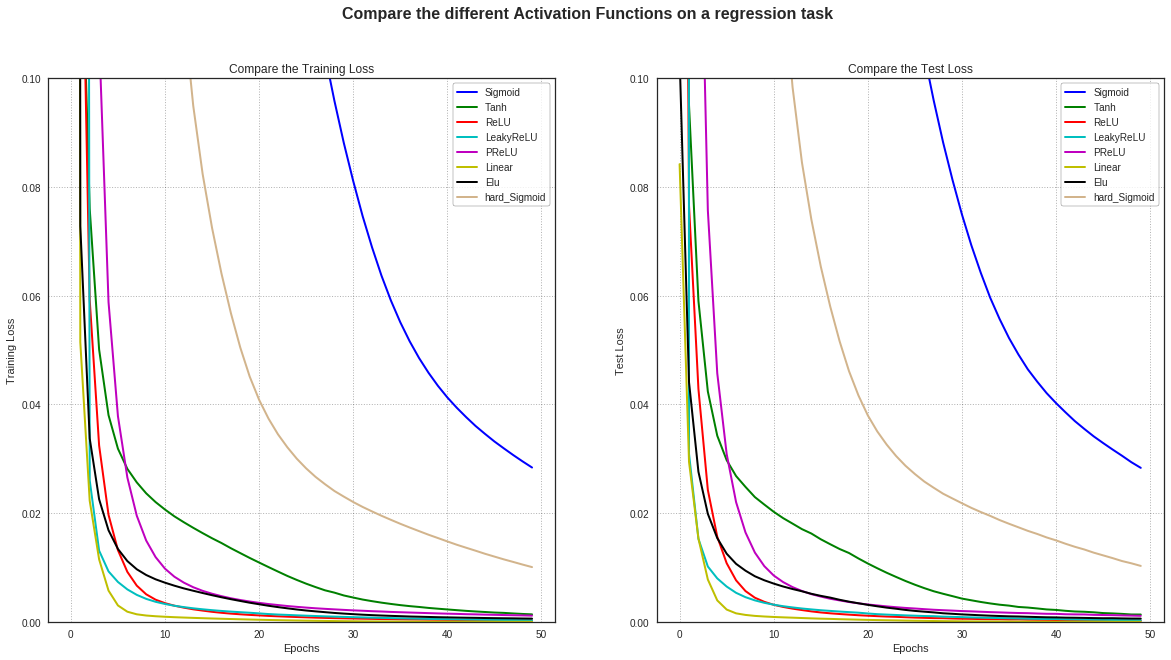

In [85]:

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))


ax1.plot(model_1_history.history['loss'],color='b',linewidth=2,label='Sigmoid')
ax1.plot(model_2_history.history['loss'],color='g',linewidth=2,label='Tanh')
ax1.plot(model_3_history.history['loss'],color='r',linewidth=2,label='ReLU')
ax1.plot(model_4_history.history['loss'],color='c',linewidth=2,label='LeakyReLU')
ax1.plot(model_5_history.history['loss'],color='m',linewidth=2,label='PReLU')
ax1.plot(model_6_history.history['loss'],color='y',linewidth=2,label='Linear')
ax1.plot(model_7_history.history['loss'],color='k',linewidth=2,label='Elu')
ax1.plot(model_8_history.history['loss'],color='tan',linewidth=2,label='hard_Sigmoid')
ax1.legend(frameon=True,edgecolor='black')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss')
ax1.set_ylim([0,1e-1])
ax1.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax1.set_title('Compare the Training Loss')


ax2.plot(model_1_history.history['val_loss'],color='b',linewidth=2,label='Sigmoid')
ax2.plot(model_2_history.history['val_loss'],color='g',linewidth=2,label='Tanh')
ax2.plot(model_3_history.history['val_loss'],color='r',linewidth=2,label='ReLU')
ax2.plot(model_4_history.history['val_loss'],color='c',linewidth=2,label='LeakyReLU')
ax2.plot(model_5_history.history['val_loss'],color='m',linewidth=2,label='PReLU')
ax2.plot(model_6_history.history['val_loss'],color='y',linewidth=2,label='Linear')
ax2.plot(model_7_history.history['val_loss'],color='k',linewidth=2,label='Elu')
ax2.plot(model_8_history.history['val_loss'],color='tan',linewidth=2,label='hard_Sigmoid')
ax2.legend(frameon=True,edgecolor='black')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Test Loss')
ax2.set_ylim([0,1e-1])
ax2.grid(True,color='black',linestyle='dotted',linewidth=1,alpha=.3)
ax2.set_title('Compare the Test Loss')


fig.suptitle('Compare the different Activation Functions on a regression task',fontsize=16, fontweight='bold')
plt.show()